In [ ]:
!pip install segmentation_models_pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 12.2 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

In [ ]:
def compute_psnr(clean_image: torch.Tensor, denoised_image: torch.Tensor):
    clean_image = clean_image.cpu().numpy()
    denoised_image = denoised_image.cpu().numpy()

    return psnr(clean_image, denoised_image, data_range=1.0)

def compute_ssim(clean_image: torch.Tensor, denoised_image: torch.Tensor):
    clean_image = clean_image.cpu().numpy()
    denoised_image = denoised_image.cpu().numpy()

    return ssim(clean_image, denoised_image, data_range=1.0)

# Vaniila NN

Epoch 1/10, Loss: 0.0315
Epoch 2/10, Loss: 0.0021
Epoch 3/10, Loss: 0.0016
Epoch 4/10, Loss: 0.0019
Epoch 5/10, Loss: 0.0012
Epoch 6/10, Loss: 0.0014
Epoch 7/10, Loss: 0.0012
Epoch 8/10, Loss: 0.0015
Epoch 9/10, Loss: 0.0010
Epoch 10/10, Loss: 0.0008


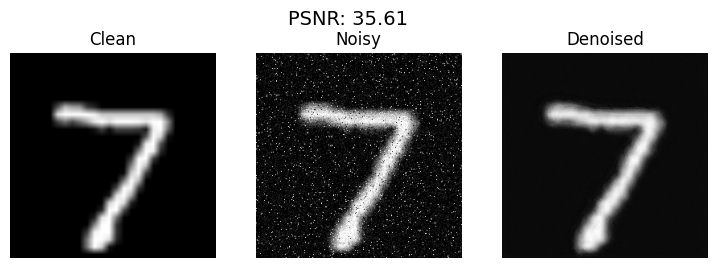

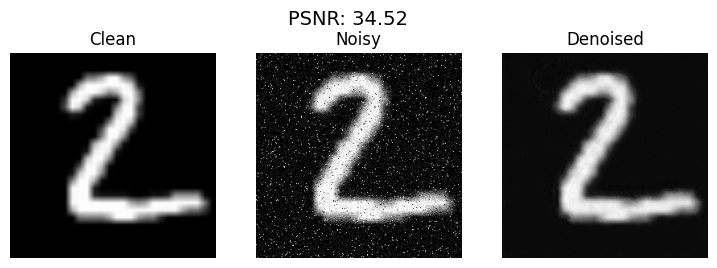

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# ----------------------------
# PSNR and SSIM
# ----------------------------
def compute_psnr(clean_image: torch.Tensor, denoised_image: torch.Tensor):
    clean_image = clean_image.cpu().numpy()
    denoised_image = denoised_image.cpu().numpy()
    return psnr(clean_image, denoised_image, data_range=1.0)

def compute_ssim(clean_image: torch.Tensor, denoised_image: torch.Tensor):
    clean_image = clean_image.cpu().numpy()
    denoised_image = denoised_image.cpu().numpy()
    return ssim(clean_image, denoised_image, data_range=1.0)

# ----------------------------
# Noise Function
# ----------------------------
def add_noise(x, gaussian_std=0.1, sp_amount=0.02):
    x_noisy = x + torch.randn_like(x) * gaussian_std
    x_noisy = torch.clamp(x_noisy, 0, 1)
    B, C, H, W = x_noisy.shape
    num_sp = int(sp_amount * H * W)
    for i in range(B):
        coords = [torch.randint(0, s, (num_sp,)) for s in (H, W)]
        x_noisy[i, 0, coords[0], coords[1]] = 1.0  # Salt
        coords = [torch.randint(0, s, (num_sp,)) for s in (H, W)]
        x_noisy[i, 0, coords[0], coords[1]] = 0.0  # Pepper
    return x_noisy

# ----------------------------
# Dataset and Loader
# ----------------------------
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Train dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(Subset(train_dataset, range(1000)), batch_size=8, shuffle=True)

# Test dataset
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(Subset(test_dataset, range(10)), batch_size=2, shuffle=False)

# ----------------------------
# UNet Model
# ----------------------------
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights=None,
    in_channels=1,
    classes=1,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# ----------------------------
# Optimizer and Loss
# ----------------------------
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# ----------------------------
# Training Loop
# ----------------------------
num_epochs = 10  # for demo, increase for real training

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    for images, _ in train_loader:
        images = images.to(device)
        noisy_images = add_noise(images, gaussian_std=0.1, sp_amount=0.02).to(device)

        outputs = model(noisy_images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

# ----------------------------
# Visualize Test Images
# ----------------------------
model.eval()
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        noisy_images = add_noise(images, gaussian_std=0.1, sp_amount=0.02).to(device)
        outputs = model(noisy_images)

        for i in range(images.shape[0]):
            clean = images[i, 0].cpu()
            noisy = noisy_images[i, 0].cpu()
            denoised = outputs[i, 0].cpu()
            psnr_score = compute_psnr(clean, denoised)

            plt.figure(figsize=(9,3))
            plt.suptitle(f"PSNR: {psnr_score:.2f}", fontsize=14)

            plt.subplot(1,3,1)
            plt.title("Clean")
            plt.imshow(clean, cmap='gray')
            plt.axis('off')

            plt.subplot(1,3,2)
            plt.title("Noisy")
            plt.imshow(noisy, cmap='gray')
            plt.axis('off')

            plt.subplot(1,3,3)
            plt.title("Denoised")
            plt.imshow(denoised, cmap='gray')
            plt.axis('off')

            plt.show()
        break


# Vanilla NN - MRI Images

In [ ]:
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision import transforms
from PIL import Image
import glob

# ----------------------------
# Custom MRI Dataset
# ----------------------------
class MRIDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        # Get all image files inside the folder
        self.files = glob.glob(root_dir + "/*")
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]
        image = Image.open(img_path).convert("L")  # convert to grayscale
        if self.transform:
            image = self.transform(image)
        return image   # no labels, just the image

# ----------------------------
# Transform
# ----------------------------
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# ----------------------------
# Load Dataset
# ----------------------------
dataset = MRIDataset("./Images", transform=transform)
print(f"Found {len(dataset)} MRI images")

# ----------------------------
# Split into train(10) / val(5) / test(5)
# ----------------------------
train_size, val_size, test_size = 10, 5, 5
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


Found 20 MRI images


Found 20 MRI images
Epoch 1/20, Train Loss: 0.5891, Val Loss: 16198.8415
Epoch 2/20, Train Loss: 0.2320, Val Loss: 400.5886
Epoch 3/20, Train Loss: 0.0846, Val Loss: 5.9348
Epoch 4/20, Train Loss: 0.0353, Val Loss: 2.2940
Epoch 5/20, Train Loss: 0.0221, Val Loss: 0.5277
Epoch 6/20, Train Loss: 0.0165, Val Loss: 0.0255
Epoch 7/20, Train Loss: 0.0121, Val Loss: 0.0136
Epoch 8/20, Train Loss: 0.0089, Val Loss: 0.0099
Epoch 9/20, Train Loss: 0.0082, Val Loss: 0.0082
Epoch 10/20, Train Loss: 0.0068, Val Loss: 0.0063
Epoch 11/20, Train Loss: 0.0064, Val Loss: 0.0057
Epoch 12/20, Train Loss: 0.0059, Val Loss: 0.0054
Epoch 13/20, Train Loss: 0.0054, Val Loss: 0.0049
Epoch 14/20, Train Loss: 0.0056, Val Loss: 0.0047
Epoch 15/20, Train Loss: 0.0050, Val Loss: 0.0045
Epoch 16/20, Train Loss: 0.0053, Val Loss: 0.0045
Epoch 17/20, Train Loss: 0.0056, Val Loss: 0.0042
Epoch 18/20, Train Loss: 0.0048, Val Loss: 0.0044
Epoch 19/20, Train Loss: 0.0048, Val Loss: 0.0041
Epoch 20/20, Train Loss: 0.0051, 

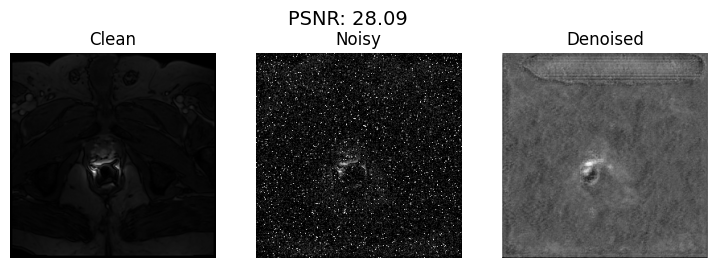

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision import transforms
from PIL import Image
import glob
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# ----------------------------
# Custom MRI Dataset
# ----------------------------
class MRIDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        # Get all image files inside the folder
        self.files = glob.glob(root_dir + "/*")
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]
        image = Image.open(img_path).convert("L")  # grayscale
        if self.transform:
            image = self.transform(image)
        return image   # no labels, just the image

# ----------------------------
# PSNR and SSIM
# ----------------------------
def compute_psnr(clean_image: torch.Tensor, denoised_image: torch.Tensor):
    clean_image = clean_image.cpu().numpy()
    denoised_image = denoised_image.cpu().numpy()
    return psnr(clean_image, denoised_image, data_range=1.0)

def compute_ssim(clean_image: torch.Tensor, denoised_image: torch.Tensor):
    clean_image = clean_image.cpu().numpy()
    denoised_image = denoised_image.cpu().numpy()
    return ssim(clean_image, denoised_image, data_range=1.0)

# ----------------------------
# Noise Function
# ----------------------------
def add_noise(x, gaussian_std=0.1, sp_amount=0.02):
    x_noisy = x + torch.randn_like(x) * gaussian_std
    x_noisy = torch.clamp(x_noisy, 0, 1)
    B, C, H, W = x_noisy.shape
    num_sp = int(sp_amount * H * W)
    for i in range(B):
        coords = [torch.randint(0, s, (num_sp,)) for s in (H, W)]
        x_noisy[i, 0, coords[0], coords[1]] = 1.0  # Salt
        coords = [torch.randint(0, s, (num_sp,)) for s in (H, W)]
        x_noisy[i, 0, coords[0], coords[1]] = 0.0  # Pepper
    return x_noisy

# ----------------------------
# Transform
# ----------------------------
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# ----------------------------
# Load Dataset
# ----------------------------
dataset = MRIDataset("./Images", transform=transform)
print(f"Found {len(dataset)} MRI images")

# Split into train(10) / val(5) / test(5)
train_size, val_size, test_size = 10, 5, 5
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# ----------------------------
# UNet Model
# ----------------------------
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights=None,
    in_channels=1,
    classes=1,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# ----------------------------
# Optimizer and Loss
# ----------------------------
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# ----------------------------
# Training Loop
# ----------------------------
num_epochs = 20  # for demo, increase for real training

for epoch in range(num_epochs):
    # ---- Training ----
    model.train()
    running_loss = 0
    for images in train_loader:   # only images now
        images = images.to(device)
        noisy_images = add_noise(images, gaussian_std=0.1, sp_amount=0.02).to(device)

        outputs = model(noisy_images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # ---- Validation ----
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images in val_loader:
            images = images.to(device)
            noisy_images = add_noise(images).to(device)
            outputs = model(noisy_images)
            val_loss += criterion(outputs, images).item()

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {running_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")

# ----------------------------
# Visualize Test Images
# ----------------------------
model.eval()
with torch.no_grad():
    for images in test_loader:
        images = images.to(device)
        noisy_images = add_noise(images, gaussian_std=0.1, sp_amount=0.02).to(device)
        outputs = model(noisy_images)

        for i in range(images.shape[0]):
            clean = images[i, 0].cpu()
            noisy = noisy_images[i, 0].cpu()
            denoised = outputs[i, 0].cpu()
            psnr_score = compute_psnr(clean, denoised)

            plt.figure(figsize=(9,3))
            plt.suptitle(f"PSNR: {psnr_score:.2f}", fontsize=14)

            plt.subplot(1,3,1)
            plt.title("Clean")
            plt.imshow(clean, cmap='gray')
            plt.axis('off')

            plt.subplot(1,3,2)
            plt.title("Noisy")
            plt.imshow(noisy, cmap='gray')
            plt.axis('off')

            plt.subplot(1,3,3)
            plt.title("Denoised")
            plt.imshow(denoised, cmap='gray')
            plt.axis('off')

            plt.show()
        break


# Vanilla NN - MRI Images with K-space

Found 20 MRI images
Epoch 1/20, Train Loss: 0.4498, Val Loss: 0.0102
Epoch 2/20, Train Loss: 0.0893, Val Loss: 0.0241
Epoch 3/20, Train Loss: 0.0352, Val Loss: 0.0257
Epoch 4/20, Train Loss: 0.0207, Val Loss: 0.0094
Epoch 5/20, Train Loss: 0.0135, Val Loss: 0.0052
Epoch 6/20, Train Loss: 0.0102, Val Loss: 0.0046
Epoch 7/20, Train Loss: 0.0084, Val Loss: 0.0041
Epoch 8/20, Train Loss: 0.0093, Val Loss: 0.0041
Epoch 9/20, Train Loss: 0.0079, Val Loss: 0.0039
Epoch 10/20, Train Loss: 0.0071, Val Loss: 0.0038
Epoch 11/20, Train Loss: 0.0063, Val Loss: 0.0038
Epoch 12/20, Train Loss: 0.0059, Val Loss: 0.0038
Epoch 13/20, Train Loss: 0.0053, Val Loss: 0.0038
Epoch 14/20, Train Loss: 0.0060, Val Loss: 0.0038
Epoch 15/20, Train Loss: 0.0054, Val Loss: 0.0038
Epoch 16/20, Train Loss: 0.0045, Val Loss: 0.0040
Epoch 17/20, Train Loss: 0.0050, Val Loss: 0.0037
Epoch 18/20, Train Loss: 0.0057, Val Loss: 0.0036
Epoch 19/20, Train Loss: 0.0051, Val Loss: 0.0036
Epoch 20/20, Train Loss: 0.0041, Val Lo

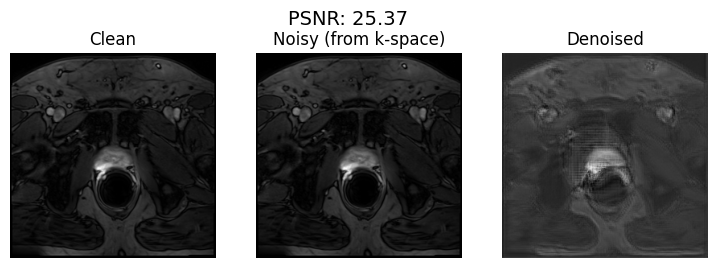

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision import transforms
from PIL import Image
import glob
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# ----------------------------
# Custom MRI Dataset
# ----------------------------
class MRIDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.files = glob.glob(root_dir + "/*")
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]
        image = Image.open(img_path).convert("L")
        if self.transform:
            image = self.transform(image)
        return image   # shape [1,H,W]

# ----------------------------
# PSNR and SSIM
# ----------------------------
def compute_psnr(clean_image: torch.Tensor, denoised_image: torch.Tensor):
    return psnr(clean_image.cpu().numpy(), denoised_image.cpu().numpy(), data_range=1.0)

def compute_ssim(clean_image: torch.Tensor, denoised_image: torch.Tensor):
    return ssim(clean_image.cpu().numpy(), denoised_image.cpu().numpy(), data_range=1.0)

# ----------------------------
# K-space utilities
# ----------------------------
def fft2c(img):
    """ Apply centered 2D FFT (image -> kspace) """
    return torch.fft.fftshift(torch.fft.fft2(torch.fft.ifftshift(img, dim=(-2,-1))), dim=(-2,-1))

def ifft2c(kspace):
    """ Apply centered 2D IFFT (kspace -> image) """
    return torch.fft.fftshift(torch.fft.ifft2(torch.fft.ifftshift(kspace, dim=(-2,-1))), dim=(-2,-1)).real

def add_kspace_noise(img, gaussian_std=0.02):
    """ Add Gaussian noise in k-space """
    kspace = fft2c(img)                       # [B,1,H,W] -> kspace
    noise = (torch.randn_like(kspace) + 1j*torch.randn_like(kspace)) * gaussian_std
    kspace_noisy = kspace + noise             # add complex noise
    img_noisy = ifft2c(kspace_noisy)          # back to image domain
    return torch.clamp(img_noisy, 0, 1)

# ----------------------------
# Transform
# ----------------------------
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# ----------------------------
# Load Dataset
# ----------------------------
dataset = MRIDataset("./Images", transform=transform)
print(f"Found {len(dataset)} MRI images")

train_size, val_size, test_size = 10, 5, 5
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# ----------------------------
# UNet Model
# ----------------------------
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights=None,
    in_channels=1,
    classes=1,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# ----------------------------
# Optimizer and Loss
# ----------------------------
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# ----------------------------
# Training Loop
# ----------------------------
num_epochs = 20

for epoch in range(num_epochs):
    # ---- Training ----
    model.train()
    running_loss = 0
    for images in train_loader:
        images = images.to(device)                  # clean
        noisy_images = add_kspace_noise(images).to(device)  # noisy from k-space

        outputs = model(noisy_images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # ---- Validation ----
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images in val_loader:
            images = images.to(device)
            noisy_images = add_kspace_noise(images).to(device)
            outputs = model(noisy_images)
            val_loss += criterion(outputs, images).item()

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {running_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")

# ----------------------------
# Visualize Test Images
# ----------------------------
model.eval()
with torch.no_grad():
    for images in test_loader:
        images = images.to(device)
        noisy_images = add_kspace_noise(images).to(device)
        outputs = model(noisy_images)

        for i in range(images.shape[0]):
            clean = images[i, 0].cpu()
            noisy = noisy_images[i, 0].cpu()
            denoised = outputs[i, 0].cpu()
            psnr_score = compute_psnr(clean, denoised)

            plt.figure(figsize=(9,3))
            plt.suptitle(f"PSNR: {psnr_score:.2f}", fontsize=14)

            plt.subplot(1,3,1)
            plt.title("Clean")
            plt.imshow(clean, cmap='gray')
            plt.axis('off')

            plt.subplot(1,3,2)
            plt.title("Noisy (from k-space)")
            plt.imshow(noisy, cmap='gray')
            plt.axis('off')

            plt.subplot(1,3,3)
            plt.title("Denoised")
            plt.imshow(denoised, cmap='gray')
            plt.axis('off')

            plt.show()
        break


# DnCNN-B

https://github.com/yjn870/DnCNN-pytorch

In [ ]:
!git clone https://github.com/yjn870/DnCNN-pytorch.git

Cloning into 'DnCNN-pytorch'...
remote: Enumerating objects: 23, done.
remote: Total 23 (delta 0), reused 0 (delta 0), pack-reused 23 (from 1)
Receiving objects: 100% (23/23), 4.18 MiB | 18.86 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [ ]:
# ----------------------------
# Clone repo (run once in Colab)
# ----------------------------
!git clone https://github.com/yjn870/DnCNN-pytorch.git

# ----------------------------
# Imports
# ----------------------------
import sys
sys.path.append("./DnCNN-pytorch")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import random

from model import DnCNN

# ----------------------------
# PSNR and SSIM
# ----------------------------
def compute_psnr(clean_image: torch.Tensor, denoised_image: torch.Tensor):
    clean_image = clean_image.cpu().numpy()
    denoised_image = denoised_image.cpu().numpy()
    return psnr(clean_image, denoised_image, data_range=1.0)

def compute_ssim(clean_image: torch.Tensor, denoised_image: torch.Tensor):
    clean_image = clean_image.cpu().numpy()
    denoised_image = denoised_image.cpu().numpy()
    return ssim(clean_image, denoised_image, data_range=1.0)

# ----------------------------
# Blind Gaussian Noise
# ----------------------------
def add_noise(x, sigma_range=(0, 55)):
    sigma = random.uniform(*sigma_range) / 255.0  # normalize to [0,1]
    noisy = x + torch.randn_like(x) * sigma
    return torch.clamp(noisy, 0, 1)

# ----------------------------
# Dataset and Loader
# ----------------------------
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(Subset(train_dataset, range(1000)), batch_size=8, shuffle=True)

test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(Subset(test_dataset, range(10)), batch_size=2, shuffle=False)

# ----------------------------
# DnCNN-B Model
# ----------------------------
model = DnCNN(num_layers=20)  # from repo, hardcoded 17-layer blind Gaussian model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# ----------------------------
# Optimizer and Loss
# ----------------------------
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# ----------------------------
# Training Loop
# ----------------------------
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    for images, _ in train_loader:
        images = images.to(device)
        # repeat grayscale to 3 channels for DnCNN-B
        images_3c = images.repeat(1, 3, 1, 1)
        noisy_images = add_noise(images_3c, sigma_range=(0, 55)).to(device)

        outputs = model(noisy_images)
        loss = criterion(outputs, images_3c)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

# ----------------------------
# Visualize Test Images
# ----------------------------
model.eval()
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        images_3c = images.repeat(1, 3, 1, 1)
        noisy_images = add_noise(images_3c, sigma_range=(0, 55)).to(device)
        outputs = model(noisy_images)

        for i in range(images.shape[0]):
            clean = images[i, 0].cpu()
            noisy = noisy_images[i, 0].cpu()
            denoised = outputs[i, 0].cpu()
            psnr_score = compute_psnr(clean, denoised)

            plt.figure(figsize=(9,3))
            plt.suptitle(f"PSNR: {psnr_score:.2f}", fontsize=14)

            plt.subplot(1,3,1)
            plt.title("Clean")
            plt.imshow(clean, cmap='gray')
            plt.axis('off')

            plt.subplot(1,3,2)
            plt.title("Noisy")
            plt.imshow(noisy, cmap='gray')
            plt.axis('off')

            plt.subplot(1,3,3)
            plt.title("Denoised")
            plt.imshow(denoised, cmap='gray')
            plt.axis('off')

            plt.show()
        break


fatal: destination path 'DnCNN-pytorch' already exists and is not an empty directory.


KeyboardInterrupt: 

In [ ]:
import os
import random
import glob
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset as TorchDataset

class Dataset(TorchDataset):
    def __init__(self, images_dir, patch_size,
                 gaussian_noise_level=(0,55),
                 downsampling_factor=None,
                 jpeg_quality=None,
                 use_fast_loader=False):
        self.image_files = sorted(glob.glob(os.path.join(images_dir, "*")))
        self.patch_size = patch_size
        self.gaussian_noise_level = gaussian_noise_level
        self.downsampling_factor = downsampling_factor
        self.jpeg_quality = jpeg_quality
        self.use_fast_loader = use_fast_loader

    def __getitem__(self, idx):
        # Load image with PIL
        clean_image = Image.open(self.image_files[idx]).convert("RGB")

        # Random crop
        crop_x = random.randint(0, clean_image.width - self.patch_size)
        crop_y = random.randint(0, clean_image.height - self.patch_size)
        clean_image = clean_image.crop((crop_x, crop_y,
                                        crop_x + self.patch_size,
                                        crop_y + self.patch_size))

        # Convert to numpy
        clean_np = np.array(clean_image).astype(np.float32)

        # Gaussian noise
        if self.gaussian_noise_level is not None:
            sigma = random.randint(self.gaussian_noise_level[0], self.gaussian_noise_level[1])
            noise = np.random.normal(0, sigma, clean_np.shape).astype(np.float32)
        else:
            noise = np.zeros_like(clean_np)

        # Add noise
        noisy_np = clean_np + noise

        # Normalize to [0,1]
        clean_np /= 255.0
        noisy_np /= 255.0

        # HWC -> CHW
        input_tensor = torch.from_numpy(np.transpose(noisy_np, (2,0,1)))
        label_tensor = torch.from_numpy(np.transpose(clean_np, (2,0,1)))

        return input_tensor, label_tensor

    def __len__(self):
        return len(self.image_files)


fatal: destination path 'DnCNN-pytorch' already exists and is not an empty directory.


Epoch 1/20:   0%|          | 0/60000 [00:00<?, ?it/s]/tmp/ipython-input-3793412341.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs).to(device)
/tmp/ipython-input-3793412341.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)
Epoch 20/20: 100%|██████████| 60000/60000 [01:20<00:00, 741.21it/s, loss=0.035679]


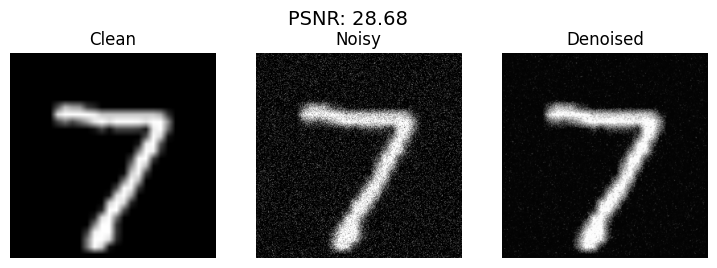

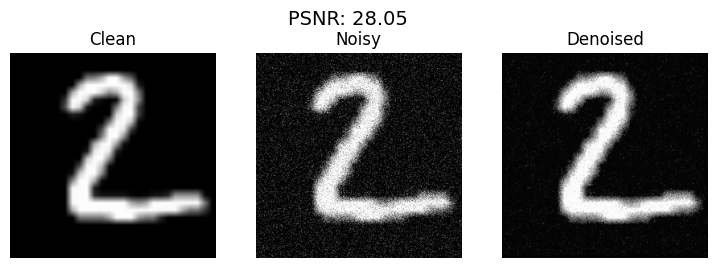

In [ ]:
# ----------------------------
# Clone repo (run once in Colab)
# ----------------------------
!git clone https://github.com/yjn870/DnCNN-pytorch.git

# ----------------------------
# Imports
# ----------------------------
import sys
sys.path.append("./DnCNN-pytorch")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from pathlib import Path
import random
import numpy as np
from PIL import Image

from model import DnCNN

# ----------------------------
# Set Parameters
# ----------------------------
images_dir = Path("./mnist_images")
images_dir.mkdir(exist_ok=True)

outputs_dir = Path("./DnCNN-B-weights")
outputs_dir.mkdir(exist_ok=True)

patch_size = 28
batch_size = 16
num_epochs = 20
lr = 1e-3
sigma_range = (0, 55)
threads = 8
seed = 123
torch.manual_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# Save MNIST as images for Dataset
# ----------------------------
train_dataset_mnist = datasets.MNIST(root='./data', train=True, download=True)
for idx, (img, _) in enumerate(train_dataset_mnist):
    img = transforms.ToPILImage()(transforms.ToTensor()(img))
    img.save(images_dir / f"{idx}.png")

# ----------------------------
# Dataset and DataLoader
# ----------------------------
dataset = Dataset(
    images_dir=str(images_dir),
    patch_size=patch_size,
    gaussian_noise_level=list(sigma_range),
    downsampling_factor=None,
    jpeg_quality=None,
    use_fast_loader=True
)

dataloader = DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=threads,
    pin_memory=True,
    drop_last=True
)

# ----------------------------
# DnCNN-B Model
# ----------------------------
model = DnCNN(num_layers=20)  # 20-layer blind Gaussian
model = model.to(device)

# ----------------------------
# Optimizer and Loss
# ----------------------------
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss(reduction='sum')

# ----------------------------
# Blind Gaussian Noise Helper
# ----------------------------
def add_noise(x, sigma_range=(0, 55)):
    sigma = random.uniform(*sigma_range) / 255.0
    noisy = x + torch.randn_like(x) * sigma
    return torch.clamp(noisy, 0, 1)

# ----------------------------
# Training Loop
# ----------------------------
from tqdm import tqdm

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    with tqdm(total=len(dataset) - len(dataset) % batch_size) as _tqdm:
        _tqdm.set_description(f"Epoch {epoch+1}/{num_epochs}")
        for inputs, labels in dataloader:
            inputs = torch.tensor(inputs).to(device)
            labels = torch.tensor(labels).to(device)

            preds = model(inputs)
            loss = criterion(preds, labels) / (2 * len(inputs))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            _tqdm.set_postfix(loss=f"{epoch_loss/(_tqdm.n + 1):.6f}")
            _tqdm.update(len(inputs))

    # Save checkpoint
    torch.save(model.state_dict(), outputs_dir / f"DnCNN-B_epoch_{epoch}.pth")

# ----------------------------
# Visualize Test Images
# ----------------------------
test_dataset_mnist = datasets.MNIST(root='./data', train=False, download=True,
                                    transform=transforms.Compose([transforms.Resize((256,256)),
                                                                  transforms.ToTensor()]))

test_loader = DataLoader(test_dataset_mnist, batch_size=2, shuffle=False)

model.eval()
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        images_3c = images.repeat(1, 3, 1, 1)  # replicate grayscale to 3 channels
        noisy_images = add_noise(images_3c, sigma_range=sigma_range).to(device)
        outputs = model(noisy_images)

        for i in range(images.shape[0]):
            clean = images[i, 0].cpu()
            noisy = noisy_images[i, 0].cpu()
            denoised = outputs[i, 0].cpu()
            psnr_score = psnr(clean.numpy(), denoised.numpy(), data_range=1.0)

            plt.figure(figsize=(9,3))
            plt.suptitle(f"PSNR: {psnr_score:.2f}", fontsize=14)

            plt.subplot(1,3,1)
            plt.title("Clean")
            plt.imshow(clean, cmap='gray')
            plt.axis('off')

            plt.subplot(1,3,2)
            plt.title("Noisy")
            plt.imshow(noisy, cmap='gray')
            plt.axis('off')

            plt.subplot(1,3,3)
            plt.title("Denoised")
            plt.imshow(denoised, cmap='gray')
            plt.axis('off')

            plt.show()
        break
